In [1]:
!pip install -U tensorflow_text==2.15.*
!pip install tf-models-official==2.15.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 28.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=32af7e7ff4f8443f7d3dd028fb89c0a3e32dfe9925fbb9a044c958026ce0ea02
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization
from tensorflow.keras import layers
from tensorflow.keras import losses

# Import dataset

This is a multi-label classification problem in which we'll use the dataset with 7 labels (harmful, severve, obscene, threat, insult, discriminate and normal). The dataset has been preprocessed, cleaned and made balanced, ready to feed into model.

In [3]:
path = 'drive/MyDrive/dataset/multilabel_comment_dataset.csv'

dataset = pd.read_csv(path, encoding = 'utf8')

dataset.head()

,comment_text,harmful,severe,obscene,threat,insult,discriminate,normal
0,bangladeshi cyclists i notice you did a name c...,0,0,0,0,0,0,1
1,in the ass bitch fucking cock sucker,1,1,1,0,1,1,0
2,ur so immature frnziim and ur not evn debating...,1,0,1,0,1,1,0
3,hi goodday i have noted that qwyrxian has weig...,0,0,0,0,0,0,1
4,for fucks sake just fucking stop you spastic a...,1,1,1,0,1,0,0


The data then is splitted in to 3 parts:

*   Training dataset: feed into model for training the behaviour (50% of whole data)
*   Validation dataset: use to validate the model whether it is fit, overfit or underfit (30%)
*   Testing dataset: use for test and evaluation of the model (20%)

Instead of taking 70% data for training like previous model, we only take 50% to reduce the training time for BERT model.

In [4]:
raw_train, raw_validation, raw_test = np.split(
    dataset.sample(frac=1),
    [int(0.5*len(dataset)), int(0.8*len(dataset))]
)

print(f'{len(raw_train)} training examples')
print(f'{len(raw_validation)} validation examples')
print(f'{len(raw_test)} test examples')

143323 training examples
85993 validation examples
57330 test examples


Since we work with Tensorflow, we need to convert pandas Dataframe to Tensorflow Dataset. The data is shuffling to ensure the random order and avoid bias. Meanwhile, the **batch**  function is called to divide data into smaller group with of size **batch_size**.

In [26]:
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df[['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal']].values
  df = df['comment_text'].values
  ds = tf.data.Dataset.from_tensor_slices((df, labels))

  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))

  ds = ds.batch(batch_size)
  return ds

raw_train_ds = dataframe_to_dataset(raw_train)
raw_val_ds = dataframe_to_dataset(raw_validation)
raw_test_ds = dataframe_to_dataset(raw_test)

In addition, **cache(**) caches the dataset in memory to avoid bottlenecks and **prefetch** prefetches data for optimal performance, allowing for the automatic tuning of the buffer size.

In [27]:
train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# BERT Model

In [28]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [29]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess)
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder)
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]

  net = layers.Dense(256, activation="relu")(net)
  net = layers.Dropout(0.2)(net)
  net = layers.Dense(64, activation='relu')(net)
  net = layers.Dropout(0.2)(net)
  net = layers.Dense(7, activation="sigmoid")(net)

  return tf.keras.Model(text_input, net)

In [30]:
model = build_model()

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer_6 (KerasLayer)  {'input_word_ids': (None,    0         ['input_4[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [31]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model.compile(
  loss=losses.BinaryCrossentropy(),
  optimizer=optimizer,
  metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)]
)

# Training

In [32]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
4479/4479 [==============================] - 1543s 344ms/step - loss: 0.3658 - binary_accuracy: 0.8265 - val_loss: 0.2732 - val_binary_accuracy: 0.8809
Epoch 2/5
4479/4479 [==============================] - 1447s 323ms/step - loss: 0.2738 - binary_accuracy: 0.8812 - val_loss: 0.2535 - val_binary_accuracy: 0.8927
Epoch 3/5
4479/4479 [==============================] - 1288s 288ms/step - loss: 0.2571 - binary_accuracy: 0.8890 - val_loss: 0.2414 - val_binary_accuracy: 0.8969
Epoch 4/5
4479/4479 [==============================] - 1249s 279ms/step - loss: 0.2476 - binary_accuracy: 0.8937 - val_loss: 0.2322 - val_binary_accuracy: 0.9015
Epoch 5/5
4479/4479 [==============================] - 1293s 289ms/step - loss: 0.2422 - binary_accuracy: 0.8964 - val_loss: 0.2286 - val_binary_accuracy: 0.9030


# Evaluation

The diagram below shows the training/ validation loss and accuracy over epochs helping us visualize the model's learning process and performance.

In [43]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss:     {loss}")
print(f"Accuracy: {accuracy}")

4479/4479 [==============================] - 642s 143ms/step - loss: 0.2286 - binary_accuracy: 0.9030
Loss:     0.22856664657592773
Accuracy: 0.9030382037162781


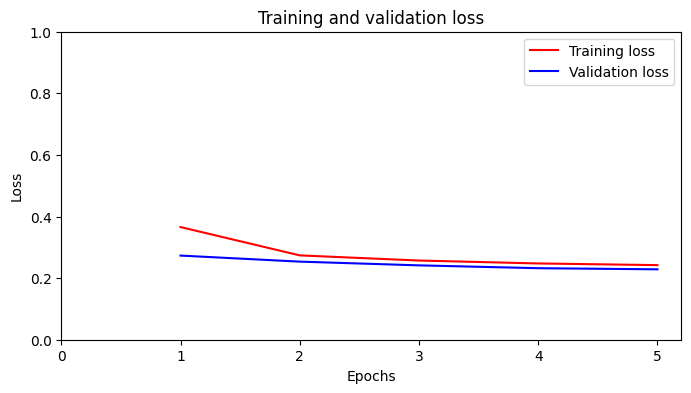

In [35]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend()

plt.show()

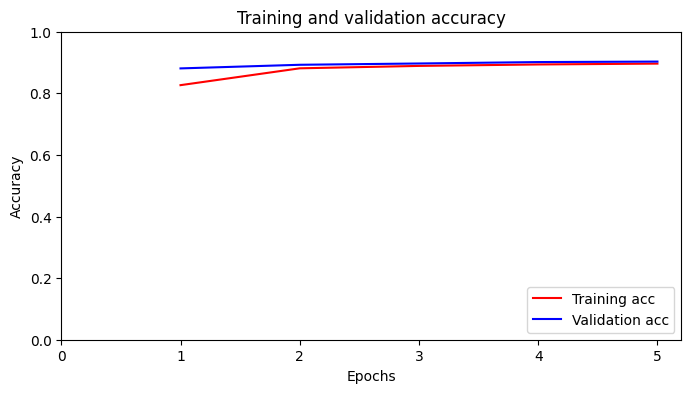

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend(loc='lower right')

plt.show()

# Export model

Having fine-tuned and trained the model, we now have a look at how model predicts a few comments (not in the dataset). Notice that the bar is highlighted red when the outcome is larger than 50%.

1/1 [==============================] - 1s 786ms/step
Dear god this site is horrible.


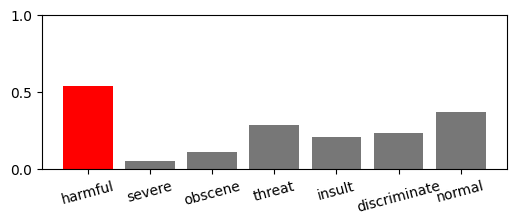

Only a fool can believe in such numbers.


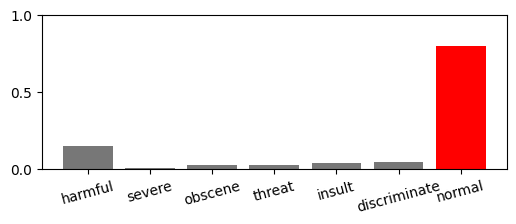

I have indefinitely blocked this account.


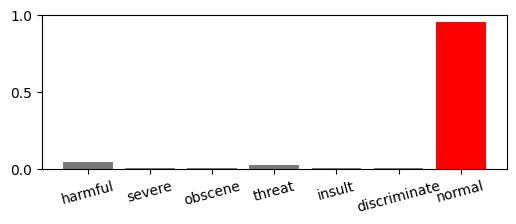

Love the commitment bitch


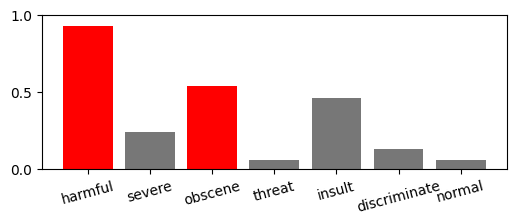

hello how are you


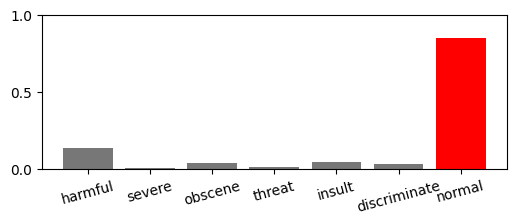

I hate gay people


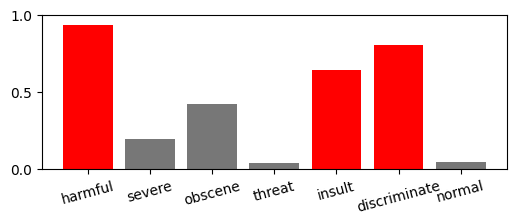

I hate myself


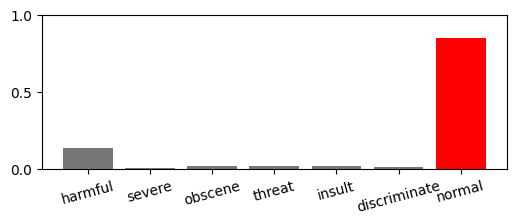

This video is awesome


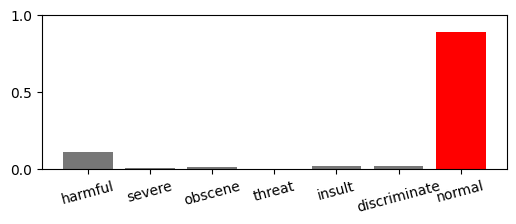

You suck


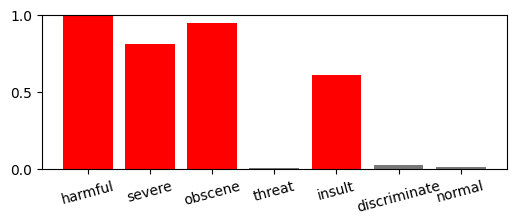

In [37]:
inputs = [
  "Dear god this site is horrible.",
  "Only a fool can believe in such numbers.",
  "I have indefinitely blocked this account.",
  "Love the commitment bitch",
  "hello how are you",
  "I hate gay people",
  "I hate myself",
  "This video is awesome",
  "You suck"
]

examples = tf.constant(inputs)
def plot_value_array(prediction):
  colors=["red" if pred >= 0.5 else "#777777" for pred in prediction]
  thisplot = plt.bar(range(len(prediction)), prediction, color=colors)
  plt.xticks(range(len(prediction)), ['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal'], rotation=15)
  plt.yticks([0, 0.5, 1])
  plt.ylim([0, 1])

predictions = model.predict(examples)

for i in range(len(inputs)):
  plt.figure(figsize=(6, 2))
  print(inputs[i])
  plot_value_array(predictions[i])
  plt.show()

Lastly, the trained model is saved and ready for deployment.

In [42]:
model.save('drive/MyDrive/saved-models/BERT-NN-model.keras')